In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import matplotlib.pyplot as plt

In [2]:
def z2p(b, se):
    z = b / se
    return stats.norm.cdf(-np.abs(z), loc=0, scale=1) * 2

# About

Here we compare eQTL results from GTEx v8 against mixQTL results on the full transcriptome in whole blood.
QQ plot is drawn using all variant/gene pairs with nominal p-value < 0.05 for each method separately.

# Load data and results

## Loading eQTL 

In [3]:
intermediate_parquet = '/vol/bmd/yanyul/UKB/GTExV8/Whole_Blood.pval_gt_0.05.parquet'
if not os.path.isfile(intermediate_parquet):
    eqtl_file = '/vol/bmd/yanyul/UKB/GTExV8/Whole_Blood.allpairs.txt.gz'
    eqtl = pd.read_csv(eqtl_file, header=0, sep='\t', compression='gzip')
    eqtl['pval_from_z'] = z2p(eqtl[['slope']].to_numpy(), eqtl[['slope_se']].to_numpy())
    eqtl[eqtl['pval_from_z'] < 0.05].to_parquet(intermediate_parquet)
eqtl_gt_05 = pd.read_parquet(intermediate_parquet)

## Loading mixQTL

In [4]:
intermediate_parquet0 = '/vol/bmd/yanyul/UKB/GTExV8/Whole_Blood.mixqtl_meta.pval_gt_0.05.parquet'
intermediate_parquet1 = '/vol/bmd/yanyul/UKB/GTExV8/Whole_Blood.mixqtl_trc.pval_gt_0.05.parquet'
if not os.path.isfile(intermediate_parquet0):
    mixqtl_file = '/vol/bmd/yanyul/UKB/GTExV8/mixqtl/Whole_Blood_GTEx_eGene.cis_qtl_pairs.mixQTL.chr{chr}.parquet'
    chrs = [ i for i in range(1, 23) ]
    chrs.append('X')
    mixqtl = pd.DataFrame()
    mixqtl_trc = pd.DataFrame()
    for i in chrs:
        print(f'on chromosome {i}')
        tmp_ = pd.read_parquet(mixqtl_file.format(chr = i))
        mixqtl = pd.concat([mixqtl, tmp_[tmp_['pval_meta'] < 0.05]]) 
        mixqtl_trc = pd.concat([mixqtl_trc, tmp_[tmp_['pval_trc'] < 0.05]]) 
    mixqtl.to_parquet(intermediate_parquet0)
    mixqtl_trc.to_parquet(intermediate_parquet1)
mixqtl_gt_05 = pd.read_parquet(intermediate_parquet0)
mixqtl_trc_gt_05 = pd.read_parquet(intermediate_parquet1)

# Visualization

In [5]:
mixqtl_trc_gt_05['pval_trc_from_z'] = z2p(mixqtl_trc_gt_05['beta_trc'].to_numpy(), mixqtl_trc_gt_05['beta_se_trc'].to_numpy())
eqtl_gt_05['tstat'] = eqtl_gt_05['slope'] / eqtl_gt_05['slope_se']



## Comparing eQTL to mixQTL and trcQTL

In [6]:
# prepare plot function
def myplot(vec_dic, n_points=100, cutoff_in_plot=20):
#     n = 100
    cutoff = np.exp(-cutoff_in_plot)
    quantiles = np.array([ i / n_points for i in range(1, n_points) ])
    ylim = -np.log(quantiles / 20).min()
    q_dic = {}
    for i in vec_dic.keys():
        q_dic[i] = vec_dic[i].quantile(quantiles)
        q_dic[i][q_dic[i] < cutoff] = cutoff
    ax, fig = plt.subplots(nrows=1, ncols=1)

    for i in q_dic.keys():
        fig.plot(-np.log(quantiles / 20), -np.log(q_dic[i].to_numpy()), label=i)
#         fig.scatter(-np.log(quantiles / 20), -np.log(q_dic[i].to_numpy()), label=i)
    fig.plot([2, ylim], [2, ylim], color='black')
    fig.legend(loc="upper left")
    return fig


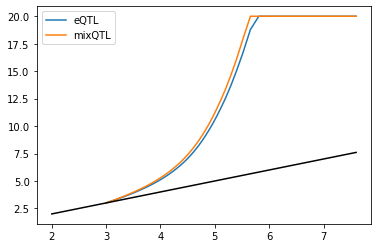

In [7]:
vec_dic = {
    'eQTL': eqtl_gt_05['pval_from_z'], 
    'mixQTL': mixqtl_gt_05['pval_meta'],
#     'trcQTL': mixqtl_trc_gt_05['pval_trc_from_z']
}
myplot(vec_dic)

## Compare eQTL to mixQTL as the ones using meta-analysis

In [8]:
mixqtl_use_meta = mixqtl_gt_05[ mixqtl_gt_05['method_meta'] == 'meta' ]
eqtl_gt_05['gene_id'] = eqtl_gt_05['gene_id'].apply(lambda x: x.split('.')[0])
eqtl_use_meta = eqtl_gt_05[ eqtl_gt_05['gene_id'].isin(mixqtl_use_meta['phenotype_id']) ]

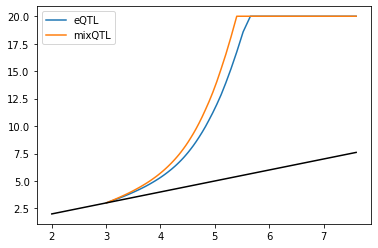

In [9]:
vec_dic = {
    'eQTL': eqtl_use_meta['pval_from_z'], 
    'mixQTL': mixqtl_use_meta['pval_meta']
}
myplot(vec_dic)

# Effective sample size

In [10]:
eqtlgen = pd.read_csv('/vol/bmd/yanyul/UKB/GTExV8/cis-eQTL_significant_20181017_with_GTExV8ID.txt.gz', header=None, sep='\t', compression='gzip')

In [11]:
eqtlgen.columns = ['Pvalue', 'SNP', 'SNPChr', 'SNPPos', 'AssessedAllele', 'OtherAllele', 'Zscore', 'Gene', 'GeneSymbol', 'GeneChr', 'GenePos', 'NrCohorts', 'NrSamples', 'FDR', 'variant_id']

In [12]:
# eqtl_file = '/vol/bmd/yanyul/UKB/GTExV8/Whole_Blood.allpairs.txt.gz'
# eqtl = pd.read_csv(eqtl_file, header=0, sep='\t', compression='gzip')
# eqtl['gene_id'] = eqtl['gene_id'].apply(lambda x: x.split('.')[0])

In [13]:
eqtl_signif = eqtl_gt_05[ eqtl_gt_05['gene_id'].isin(eqtlgen['Gene']) & eqtl_gt_05['variant_id'].isin(eqtlgen['variant_id']) ]
mixqtl_signif = mixqtl_gt_05[ mixqtl_gt_05['phenotype_id'].isin(eqtlgen['Gene']) & mixqtl_gt_05['variant_id'].isin(eqtlgen['variant_id']) ]
merge_signif = pd.merge(eqtl_signif, mixqtl_signif, left_on=['gene_id', 'variant_id'], right_on=['phenotype_id', 'variant_id'], how='inner')

In [14]:
merge_signif['ratio'] = merge_signif['tstat_meta'] ** 2 / merge_signif['tstat'] ** 2 
merge_signif['effective'] = merge_signif['ratio'] * 670

In [15]:
eqtl_signif_not = eqtl_gt_05[ ~ (eqtl_gt_05['gene_id'].isin(eqtlgen['Gene']) & eqtl_gt_05['variant_id'].isin(eqtlgen['variant_id']) )]
mixqtl_signif_not = mixqtl_gt_05[ ~ (mixqtl_gt_05['phenotype_id'].isin(eqtlgen['Gene']) & mixqtl_gt_05['variant_id'].isin(eqtlgen['variant_id']) )]
merge_signif_not = pd.merge(eqtl_signif_not, mixqtl_signif_not, left_on=['gene_id', 'variant_id'], right_on=['phenotype_id', 'variant_id'], how='inner')

In [16]:
merge_signif_not['ratio'] = merge_signif_not['tstat_meta'] ** 2 / merge_signif_not['tstat'] ** 2 
merge_signif_not['effective'] = merge_signif_not['ratio'] * 670

In [17]:
merge_signif['effective'].describe()

count    5.072701e+06
mean     8.924097e+02
std      8.909862e+02
min      1.791364e+01
25%      5.553584e+02
50%      7.010607e+02
75%      9.466854e+02
max      1.281927e+05
Name: effective, dtype: float64

In [18]:
merge_signif_not['effective'].describe()

count    4.402935e+06
mean     7.749327e+02
std      5.300383e+02
min      1.009191e+01
25%      5.451257e+02
50%      6.786497e+02
75%      8.672733e+02
max      1.234364e+05
Name: effective, dtype: float64

In [19]:
# merge_signif[merge_signif['effective'] < 100][['tstat_meta', 'tstat', 'tstat_trc', 'tstat_asc']]

In [20]:
# mixqtl_gt_05[mixqtl_gt_05['phenotype_id'] == 'ENSG00000231050']['tstat_trc'].describe()

In [21]:
# eqtl_gt_05['tstat'] = eqtl_gt_05['slope'] / eqtl_gt_05['slope_se']

In [22]:
# eqtl_gt_05[eqtl_gt_05['gene_id'] == 'ENSG00000231050']['tstat'].describe()

In [23]:
# test_pair = pd.read_csv('test-list.txt', header=0, sep='\t')

In [24]:
# meta = mixqtl_gt_05[ mixqtl_gt_05['phenotype_id'].isin(test_pair['gene']) & mixqtl_gt_05['variant_id'].isin(test_pair['variant']) ]

In [25]:
# eqtl = eqtl_gt_05[ eqtl_gt_05['gene_id'].isin(test_pair['gene']) & eqtl_gt_05['variant_id'].isin(test_pair['variant']) ]

In [26]:
# meta['tstat_trc'].describe()

In [27]:
# eqtl['tstat'].describe()

In [28]:
# mm = pd.merge(mixqtl_trc_gt_05, eqtl_gt_05, left_on=['phenotype_id', 'variant_id'], right_on=['gene_id', 'variant_id'], how='inner')

In [29]:
# plt.scatter(mm['tstat_trc'], mm['tstat'])

In [30]:
# eqtl_gt_05['tstat'].abs().min()

In [31]:
# o = mm[ (mm['tstat_trc'] - mm['tstat'] < -2) | (mm['tstat_trc'] - mm['tstat'] > 2)]
# o['phenotype_id'].unique().shape

In [32]:
# o = mm[ (mm['tstat'] - mm['tstat_trc'] < -5) ]
# o['phenotype_id'].unique().shape

In [33]:
# o = mm[ (mm['tstat'] - mm['tstat_trc'] > 5) ]
# o['phenotype_id'].unique().shape